In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set your dataset path
base_dir = "/content/drive/MyDrive/Brain_Tumor_Detection_Project/BrainTumorMRIDataset"
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Testing")

# Image settings
IMG_SIZE = 224  # You can change to 150, 224, or 256
BATCH_SIZE = 32



# Augmented data generator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for test/validation
test_datagen = ImageDataGenerator(rescale=1./255)

# Updated data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 5722 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),  # 32 filters, 3x3 kernel, input size 150x150 RGB
    MaxPooling2D(2,2),  # reduce spatial size by 2

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Dropout(0.5),  # drop 50% neurons randomly

    Flatten(),  # flatten 3D features to 1D vector
    Dense(512, activation='relu'),  # fully connected layer
    Dense(4, activation='softmax')  # 4 classes for brain tumor types
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,398,148 (169.37 MB)

 Trainable params: 44,398,148 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 1. Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # because you have 4 classes
              metrics=['accuracy'])

# 2. Train the model
history = model.fit(
    train_generator,    # your training data generator
    validation_data=test_generator,  # your validation/test data generator
    epochs= 20          # number of epochs, you can increase later
)

# 3. Evaluate the model (optional here, since fit already shows val acc)
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc*100:.2f}%')

# 4. Save the trained model for future use
model.save('/content/drive/MyDrive/Brain_Tumor_Detection_Project/models/improved_brain_tumor_cnn__model.h5')



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1472s 8s/step - accuracy: 0.4574 - loss: 1.2855 - val_accuracy: 0.6758 - val_loss: 0.8510
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 518ms/step - accuracy: 0.7115 - loss: 0.7070 - val_accuracy: 0.7483 - val_loss: 0.6902
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 516ms/step - accuracy: 0.7609 - loss: 0.6109 - val_accuracy: 0.7452 - val_loss: 0.6366
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 516ms/step - accuracy: 0.7712 - loss: 0.5742 - val_accuracy: 0.7460 - val_loss: 0.6148
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 514ms/step - accuracy: 0.7928 - loss: 0.5265 - val_accuracy: 0.6789 - val_loss: 0.9871
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 519ms/step - accuracy: 0.7969 - loss: 0.5242 - val_accuracy: 0.7796 - val_loss: 0.5587
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 517ms/step - accuracy: 0.8069 - loss: 0.4829 - val_accuracy: 0.8002 - val_loss: 0.5079
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 521ms/step - accuracy: 0.8215 - loss: 0.

Test accuracy: 88.71%


Load the Trained Model

In [8]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Brain_Tumor_Detection_Project/models/improved_brain_tumor_cnn__model.h5')

# **Evaluate the Model on the Test Set**





In [9]:
import os

# Create results folder if not exists
os.makedirs('results', exist_ok=True)

# Final training accuracy and loss from the last epoch
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)

# Prepare result string
result_str = (
    f"Train Accuracy: {train_acc * 100:.2f}%\n"
    f"Train Loss: {train_loss:.4f}\n"
    f"Test Accuracy: {test_acc * 100:.2f}%\n"
    f"Test Loss: {test_loss:.4f}\n"
)

# Print to console
print(result_str)

# Save to results folder
with open("/content/drive/MyDrive/Brain_Tumor_Detection_Project/results/improved_evaluation_results.txt", "w") as f:
    f.write(result_str)


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.8804 - loss: 0.3153
Train Accuracy: 89.79%
Train Loss: 0.2809
Test Accuracy: 88.71%
Test Loss: 0.2870



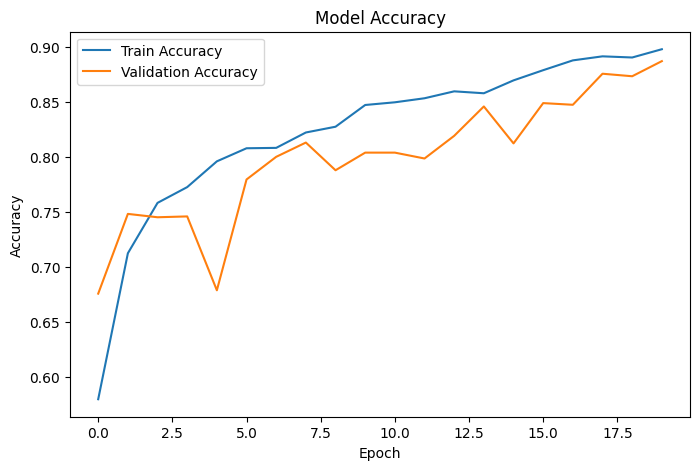

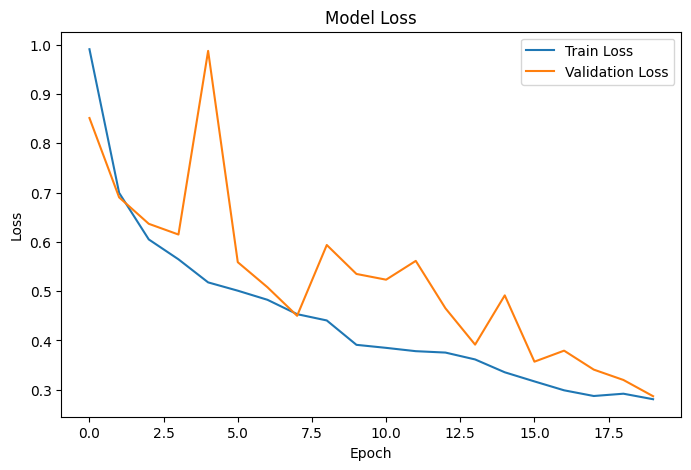

In [12]:
import matplotlib.pyplot as plt

# 📈 Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/Brain_Tumor_Detection_Project/results/improved_accuracy_plot.png')  # Save to file
plt.show()  # 👈 Show in notebook
plt.close()

# 📉 Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Brain_Tumor_Detection_Project/results/improved_loss_plot.png')  # Save to file
plt.show()  # 👈 Show in notebook
plt.close()
